<a href="https://colab.research.google.com/github/JaganFoundr/Image-Classification/blob/main/Custom_Food_Classification/FoodCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
# 1. torch related libraries
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transform

#numpy
import numpy as np

#web, path and os related libraries
import random
from pathlib import Path
import zipfile
import requests

#model running time
from timeit import default_timer as timer

#plotting library
import matplotlib.pyplot as plt

#image and loading indicator library
from PIL import Image
from tqdm.auto import tqdm

#plotting confusion matrix
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
!pip install torchmetrics
from torchmetrics import ConfusionMatrix

#current model info
!pip install torchinfo
from torchinfo import summary

In [72]:
# 2. Setting Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [73]:
# 3. Fetching the Custom Dataset from the web.

#assigning data paths.
data_path=Path("Dataset factory")
image_path=data_path/"food_classification"

#creating data paths if not exists.
if image_path.is_dir():
  print(f"{image_path} already exists, skipping download...\n")
else:
  print(f"Couldn't find directory, so creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  print("Completed\n")

#downloading the zip file from web
with open(data_path/"food_classification.zip", "wb") as f:
  print("Downloading the zip file from web...")
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)
  print("Download complete.\n")

#unzipping the zip file to the image_path
with zipfile.ZipFile(data_path/"food_classification.zip") as zip_file:
  print("Unzipping the zip file")
  zip_file.extractall(image_path)
  print("Extraction completed.")

Dataset factory/food_classification already exists, skipping download...

Download complete.

Unzipping the zip file
Extraction completed.


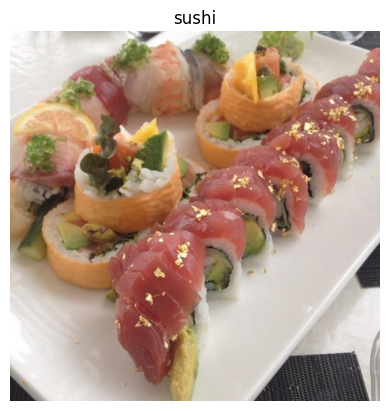


Image class: sushi
Image height: 512
Image width: 512
Image shape: (512, 512, 3)



In [74]:
#4. plotting random images of the whole dataset.
image_path=Path(image_path)
image_path_list=list(image_path.glob("*/*/*.jpg"))

random_image_list=random.choice(image_path_list)
image_label=random_image_list.parent.name

image=Image.open(random_image_list) # This is the exact image code snippet.
image_as_an_array=np.asarray(image)

def plot_image(image):
  plt.imshow(image)
  plt.title(f"{image_label}")
  plt.axis(False)
  plt.show()
plot_image(image)

print(f"\nImage class: {image_label}")
print(f"Image height: {image.height}")
print(f"Image width: {image.width}")
print(f"Image shape: {image_as_an_array.shape}\n")


TRANSFORMED IMAGE


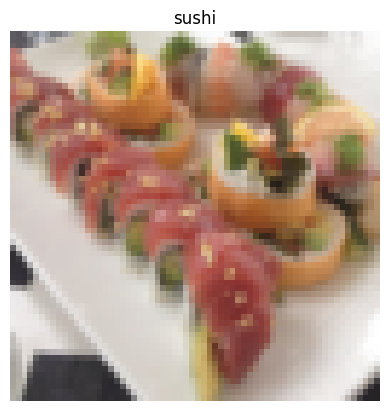


Image class: sushi

Image shape: torch.Size([3, 64, 64])


In [75]:
# 5. Transforming the images from jpg or array format to tensors and making some other changes
#and finally plotting it.

#with augment
augment_transform = transform.Compose([

    transform.TrivialAugmentWide(num_magnitude_bins=31),
    transform.Resize(size=(64,64)),
    transform.RandomHorizontalFlip(p=0.5),
    transform.ToTensor()
])

#plotting the transformed image
transformed_image=augment_transform(image)
color_image=transformed_image.permute(1,2,0)

print("\nTRANSFORMED IMAGE")
plot_image(color_image)

print(f"\nImage class: {image_label}\n")
print(f"Image shape: {transformed_image.shape}")

In [76]:
#6 .Now creating the format for training and testing dataset in order to upload to the dataloader.
train_data=ImageFolder(root=image_path/"train",transform=augment_transform, target_transform=None)
test_data=ImageFolder(root=image_path/"test",transform=augment_transform,target_transform=None)


In [77]:
#7. Preparing Dataloader
import os
batch_size = 32

train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          num_workers=os.cpu_count(),
                          shuffle=True)

test_loader = DataLoader(dataset=test_data,
                               batch_size=batch_size,
                               num_workers=os.cpu_count()
                            )

In [78]:
#8. shape of the images in the train loader
loader_image, loader_label=next(iter(test_loader))
loader_image.shape

torch.Size([32, 3, 64, 64])

In [79]:
#9. Building the food detection model
class FoodModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.cnn_block1 = nn.Sequential(

        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1), #layer 1 in block 1
        #nn.ReLU(),

        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1), #layer 2 in block 1
        #nn.ReLU(),

        nn.MaxPool2d(kernel_size=2)
    )

    self.cnn_block2 = nn.Sequential(

        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1), #layer 1 in block 2
        #nn.ReLU(),

        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1), #layer 2 in block 2
        #nn.ReLU(),

        nn.MaxPool2d(kernel_size=2)
    )

    self.cnn_block3 = nn.Sequential(

        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1), #layer 1 in block 3
        #nn.ReLU(),

        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1), #layer 2 in block 3
        #nn.ReLU(),

        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(

        nn.Flatten(), #flatten the previous layer size
        nn.Linear(hidden_units * 8 * 8, output_shape) #putting in feedforward linear layer
    )

  def forward(self, x): #forward all the layers
      out = self.cnn_block1(x)
      out = self.cnn_block2(out)
      out = self.cnn_block3(out)
      out = self.classifier(out)
      return out

torch.manual_seed(42)
# Creating CNN Model
FoodCNN = FoodModel(input_shape=3, hidden_units=64, output_shape=3).to(device)

In [80]:
FoodCNN

FoodModel(
  (cnn_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=3, bias=True)
  )
)

In [81]:
#10. Untrained Prediction
torch.manual_seed(42)
for images, labels in train_loader:
  images, labels = images.to(device), labels.to(device)
  prediction = FoodCNN(images)
  break
prediction[0]

tensor([-0.0391, -0.0068,  0.0061], grad_fn=<SelectBackward0>)

In [82]:
#11. Accuracy Function
def accuracy(output, labels):
    _, pred = torch.max(output, dim=1)
    return torch.sum(pred == labels).item() / len(pred) * 100

In [83]:
#12. Loss Function and Optimizer
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(FoodCNN.parameters(), lr=0.01)

In [84]:
#13. Model Run Time Function
def model_run_time(start_time, end_time, device=None):
    total_time = end_time - start_time
    print(f"The model took {total_time:.3f} seconds on device: {device}\n")
    return total_time

In [85]:
#14. Loss Batch Function
def loss_batch(model, loss_function, images, labels, opt, metrics=accuracy):
    prediction = FoodCNN(images)
    loss = loss_function(prediction, labels)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    metric_result = metrics(prediction, labels) if metrics else None
    return loss.item(), len(images), metric_result

In [86]:
#15. Evaluation Function
def evaluate(model, loss_function, test_loader, metrics=accuracy):
    with torch.inference_mode():
        result = [loss_batch(FoodCNN, loss_function, images.to(device), labels.to(device), opt=None, metrics=accuracy)
                  for images, labels in test_loader]

        losses, num, metric = zip(*result)
        total = np.sum(num)
        loss = np.sum(np.multiply(losses, num)) / total

        metric_result = np.sum(np.multiply(metric, num)) / total if metrics else None
        return loss, total, metric_result

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Training loss: 200085632.0000, Test loss: 528799553.7067

Training accuracy: 0.00%, Test accuracy: 32.00%
---------------------------------------------------------

Epoch 2/5
Training loss: 342483648.0000, Test loss: 341731341.6533

Training accuracy: 0.00%, Test accuracy: 41.33%
---------------------------------------------------------

Epoch 3/5
Training loss: 0.0000, Test loss: 27636484.0000

Training accuracy: 100.00%, Test accuracy: 34.67%
---------------------------------------------------------

Epoch 4/5
Training loss: 0.0000, Test loss: 23434378.4533

Training accuracy: 100.00%, Test accuracy: 45.33%
---------------------------------------------------------

Epoch 5/5
Training loss: 0.0000, Test loss: 17596912.4267

Training accuracy: 100.00%, Test accuracy: 41.33%
---------------------------------------------------------

Average Training loss is 108513856.0000

Average Test loss is 187839734.0480

Average Training accuracy is 60.00%

Average Test accuracy is 38.93%

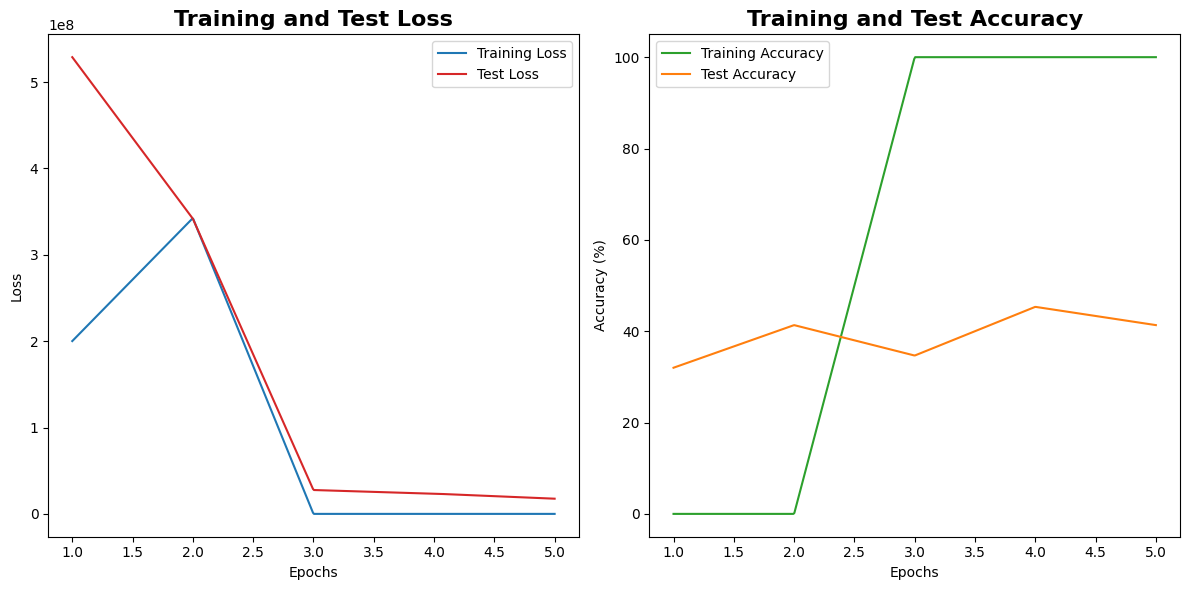

The model took 76.037 seconds on device: cpu



76.03745225900002

In [87]:
#16. Training and Plotting Function
def train_and_plot(nepochs, model, loss_function, train_loader, test_loader, opt, metrics=accuracy):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in tqdm(range(nepochs)):
        FoodCNN.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            train_loss, _, train_acc = loss_batch(FoodCNN, loss_function, images, labels, opt, metrics=accuracy)

        FoodCNN.eval()
        test_loss, _, test_acc = evaluate(FoodCNN, loss_function, test_loader, metrics=accuracy)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch + 1}/{nepochs}")
        print(f"Training loss: {train_loss:.4f}, Test loss: {test_loss:.4f}\n")
        print(f"Training accuracy: {train_acc:.2f}%, Test accuracy: {test_acc:.2f}%")
        print("---------------------------------------------------------\n")

    print(f"Average Training loss is {sum(train_losses)/len(train_losses):.4f}\n")
    print(f"Average Test loss is {sum(test_losses)/len(test_losses):.4f}\n")
    print(f"Average Training accuracy is {sum(train_accuracies)/len(train_accuracies):.2f}%\n")
    print(f"Average Test accuracy is {sum(test_accuracies)/len(test_accuracies):.2f}%\n")

    epochs = range(1, nepochs + 1)

    # Interpolate the data
    interp_epochs = np.linspace(min(epochs), max(epochs), 500)
    interp_train_losses = np.interp(interp_epochs, epochs, train_losses)
    interp_test_losses = np.interp(interp_epochs, epochs, test_losses)
    interp_train_accuracies = np.interp(interp_epochs, epochs, train_accuracies)
    interp_test_accuracies = np.interp(interp_epochs, epochs, test_accuracies)

    # Plot the interpolated curves
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(interp_epochs, interp_train_losses, label='Training Loss', color='tab:blue')
    plt.plot(interp_epochs, interp_test_losses, label='Test Loss', color='tab:red')
    plt.title('Training and Test Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(interp_epochs, interp_train_accuracies, label='Training Accuracy', color='tab:green')
    plt.plot(interp_epochs, interp_test_accuracies, label='Test Accuracy', color='tab:orange')
    plt.title('Training and Test Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracies, test_losses, test_accuracies

# Training the Model
start_time = timer()

train_losses, train_accuracies, test_losses, test_accuracies = train_and_plot(
    5, FoodCNN, loss_function, train_loader, test_loader, opt, metrics=accuracy)

end_time = timer()
model_run_time(start_time, end_time, device=device)

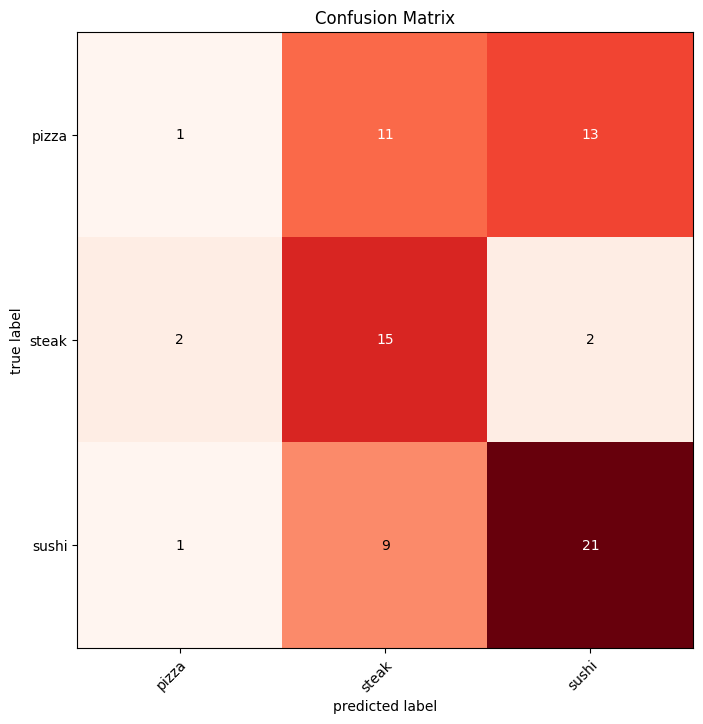

In [96]:
#17. Confusion Matrix
class_names = ["pizza", "steak","sushi"]

confusion_matrix = ConfusionMatrix(num_classes=len(class_names), task="multiclass").to(device)

all_preds, all_labels = [], []

FoodCNN.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = FoodCNN(images)
        _, preds = torch.max(outputs, dim=1)
        all_preds.append(preds)
        all_labels.append(labels)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
conf_matrix_np = confusion_matrix(all_preds, all_labels).cpu().numpy()

fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_np, class_names=class_names, figsize=(8, 8), cmap="Reds")
plt.title("Confusion Matrix")
plt.show()

In [97]:
#18. Prediction Function
def prediction(images, model):
    input = images.to(device).unsqueeze(0)
    with torch.inference_mode():
      output = FoodCNN(input)
    _, pred = torch.max(output, dim=1)
    return pred[0].item()

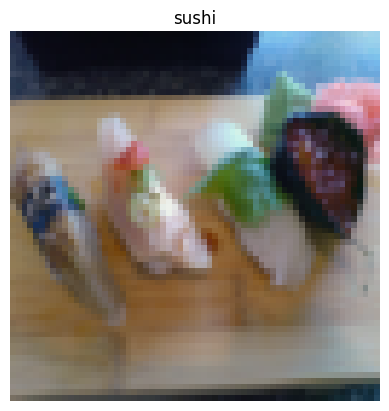


Model Prediction on Testset:  sushi


In [105]:
#19. Testing the Model
image_path=data_path/"food_classification"/"test"
image_path=Path(image_path)
image_path_list=list(image_path.glob("*/*.jpg"))

random_image_list=random.choice(image_path_list)
image_label=random_image_list.parent.name

image=Image.open(random_image_list) # This is the exact image code snippet.

transforms = transform.Compose([

    transform.Resize(size=(64,64)),
    transform.ToTensor()
])

transformed_image=transforms(image)
color_image=transformed_image.permute(1,2,0)

plt.imshow(color_image)
plt.title(f"{image_label}")
plt.axis(False);
plt.show()

print("\nModel Prediction on Testset: ", test_data.classes[prediction(transformed_image.to(device), FoodCNN)])

In [106]:
#20 Test Set Evaluation
test_loss, _, test_acc = evaluate(FoodCNN, loss_function, test_loader, metrics=accuracy)
print(f"The testset loss is {test_loss:.4f}.")
print(f"The accuracy of prediction with testset is {test_acc:.2f}%.")

The testset loss is 18473883.2267.
The accuracy of prediction with testset is 44.00%.


In [107]:
#21 Saving and Loading Model
save_model = FoodModel(input_shape=3, hidden_units=32, output_shape=3).to(device)

torch.save(save_model.state_dict(), "Pizza_Sushi_Steak_Classifier.pth")

load_model = save_model
load_model.load_state_dict(torch.load("Pizza_Sushi_Steak_Classifier.pth"))

<ipython-input-107-94921370f47e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load("Pizza_Sushi_Steak_Classifier.pth"))


<All keys matched successfully>

In [108]:
#22. current model info
model=FoodModel(input_shape=3, hidden_units=32, output_shape=3).to(device)
batch_size=32
summary(model, input_size=(batch_size, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
FoodModel                                [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 32, 64, 64]          896
│    └─Conv2d: 2-2                       [32, 32, 64, 64]          9,248
│    └─MaxPool2d: 2-3                    [32, 32, 32, 32]          --
├─Sequential: 1-2                        [32, 32, 16, 16]          --
│    └─Conv2d: 2-4                       [32, 32, 32, 32]          9,248
│    └─Conv2d: 2-5                       [32, 32, 32, 32]          9,248
│    └─MaxPool2d: 2-6                    [32, 32, 16, 16]          --
├─Sequential: 1-3                        [32, 32, 8, 8]            --
│    └─Conv2d: 2-7                       [32, 32, 16, 16]          9,248
│    └─Conv2d: 2-8                       [32, 32, 16, 16]          9,248
│    └─MaxPool2d: 2-9                    [32, 32, 8, 8]            --

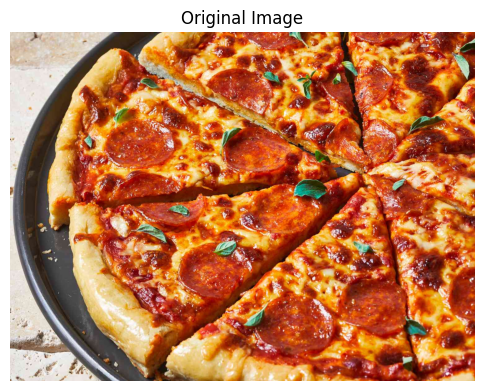


----------------------------------



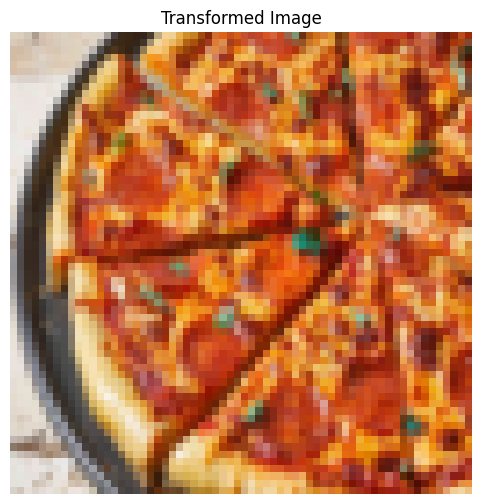

In [109]:
#23. Load the custom image
custom_image = torchvision.io.read_image("Dataset factory/my-pizza.jpg")

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(custom_image.permute(1, 2, 0))
plt.title("Original Image")
plt.axis(False)
plt.show()

print("\n----------------------------------\n")

# Define the transformation
custom_transform = transform.Compose([
    transform.Resize(size=(64, 64))# Resize to 64x64
])

# Apply the transformation
transformed_image = custom_transform(custom_image)

# Convert the transformed image to a format suitable for display
transformed_image_after_permute = transformed_image.permute(1, 2, 0)  # Change dimensions for plt.imshow

# Plot the transformed image
plt.figure(figsize=(6, 6))
plt.imshow(transformed_image_after_permute)
plt.title("Transformed Image")
plt.axis(False)
plt.show()

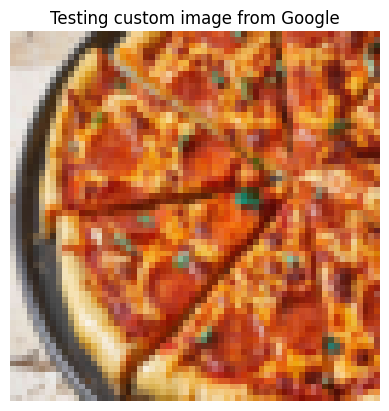


Model Prediction on custom image:  steak


In [112]:
#24. plotting the custom image and model's prediction on that image.
transformed_image=transformed_image.type(torch.float32)

plt.imshow(transformed_image_after_permute)
plt.title("Testing custom image from Google")
plt.axis(False);
plt.show()

print("\nModel Prediction on custom image: ",class_names[prediction(transformed_image.to(device), FoodCNN)])